## 1.Import libraries
The required libraries for this notebook are pandas, sklearn, numpy and matplotlib.

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import os
from tqdm.auto import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog, local_binary_pattern
import imgaug.augmenters as iaa
import pywt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm, metrics

## 2.1 Edit label.csv data
Add column for binary label: 0 for no tumor, 1 for tumor

In [97]:
df = pd.read_csv('./dataset/label.csv')
df.head()

,file_name,label
0,IMAGE_0000.jpg,meningioma_tumor
1,IMAGE_0001.jpg,no_tumor
2,IMAGE_0002.jpg,meningioma_tumor
3,IMAGE_0003.jpg,glioma_tumor
4,IMAGE_0004.jpg,meningioma_tumor


## 2.2 Add image data
Add image data in the form of an array to the label data and save it in a new pickle file so it does not need to run everytime

In [98]:
def create_binary(df):
    '''
    Inputs
        df: Label data.

    Return
        binary: List of binary labels - 0 if no tumor, 1 if tumor.
    '''

    binary = []
    for label in df['label']:
        if 'no_tumor' in label:
            binary.append(0)
        else:
            binary.append(1)
    return binary

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/454 [00:00<?, ?it/s]

IndexError: index 3 is out of bounds for axis 0 with size 3

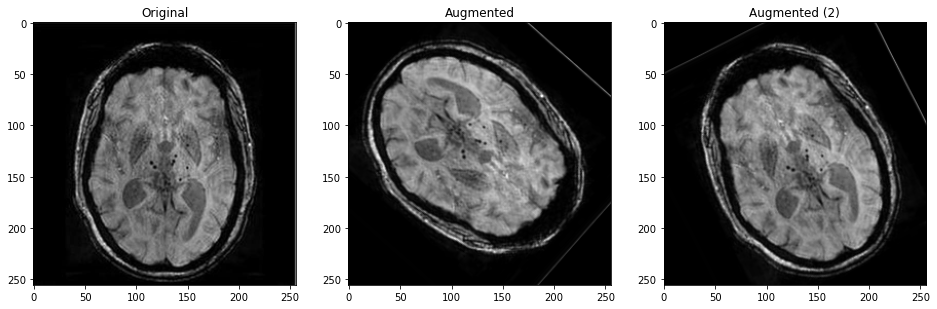

In [110]:
data_path = './dataset/image'
images = []
for filename in tqdm(df['file_name']):
    im = imread(os.path.join(data_path, filename), as_gray=True)
    coeffs = pywt.dwt2(im, 'haar')
    LL, (LH, HL, HH) = coeffs
    # DWT transforms image to (256,256) from (516,516), also for denoising
    images.append(LL)

# Index of images with no_tumor label
noTumor_idx = df.index[df['label'] == 'no_tumor'].tolist()
# List of images with no_tumor label
images_noTumor = []
for idx in tqdm(noTumor_idx):
    images_noTumor.append(images[idx])

seq1 = iaa.Sequential([
    iaa.Fliplr(1),  # horizontal flips
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.Affine(
        rotate=(-180, 180),
        shear=(-10, 10)
    )
], random_order=True)

seq2 = iaa.Sequential([
    iaa.Affine(
        rotate=(-180, 180),
        shear=(-10, 10)
    ),
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    )
], random_order=True)

seq3 = iaa.Sequential([
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5)),
        iaa.Sharpen(alpha=(0.0, 1.0), lightness=(0.75, 2.0))
    ),
    iaa.Affine(
        rotate=(-180, 180),
        shear=(-10, 10)
    )
], random_order=True)

# Quadruple the no_tumor images
images_aug_noTumor1 = seq1(images=images_noTumor)
images_aug_noTumor2 = seq2(images=images_noTumor)
images_aug_noTumor3 = seq3(images=images_noTumor)

# Concatenate the lists of image pixel data to form a new dataset with augmented images
images_new = images + images_aug_noTumor1 + images_aug_noTumor2 + images_aug_noTumor3

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 9))
# fig.suptitle('Original vs Discrete Wavelet Transformed')
axs[0].set_title('Original')
axs[0].imshow(images[1], cmap=plt.cm.gray)
axs[1].set_title('Augmented')
axs[1].imshow(images_aug_noTumor1[0], cmap=plt.cm.gray)
axs[2].set_title('Augmented (2)')
axs[2].imshow(images_aug_noTumor2[0], cmap=plt.cm.gray)
axs[3].set_title('Augmented (3)')
axs[3].imshow(images_aug_noTumor3[0], cmap=plt.cm.gray)

In [100]:
def extract_hog(images_pixelData):
    '''
    Inputs
        data_path: Directory path to images in dataset;
        df: Label data.
        
    Return
       hog_features: A list of HOG features for each image
    '''
    hog_features = []
    for i in tqdm(range(len(images_pixelData))):
        resized_im = resize(images_pixelData[i], (128, 64))
        # Extract Histogram of Oriented Gradients (HOG) for the image
        fd = hog(resized_im, orientations = 9, pixels_per_cell = (8, 8),
                            cells_per_block = (4, 4), visualize = False, block_norm='L2-Hys')
        hog_features.append(fd)

    return hog_features

if os.path.exists('./dataset/label_taskA_hog.pkl'):
    print('The pickle file for Task A with hog features data already exists')
else:
    binary = create_binary(df)
    hog_features = extract_hog(images_new)
    
    label_taskA = pd.DataFrame(data = hog_features)
    label_taskA['binary_label'] = binary + [0]*len(noTumor_idx)*3 
    label_taskA.to_pickle("./dataset/label_taskA_hog.pkl")

  0%|          | 0/3908 [00:00<?, ?it/s]

In [101]:
def extract_lbp(images_pixelData, numPoints, radius):
    '''
    Inputs
        data_path: Directory path to images in dataset;
        df: Label data.
        
    Return
       lbp_features: A list of Local Binary Pattern (LBP) features for each image
    '''

    lbp_features = []
    for i in tqdm(range(len(images_pixelData))):
        # Extract Local Binary Pattern (LBP) for the image
        lbp = local_binary_pattern(images_pixelData[i], numPoints, radius, method="uniform")
        # Create bins for histogram
        n_bins = int(lbp.max() + 1)
        # Create histogram for image
        (hist, _) = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
        
        # # normalize the histogram
        # hist = hist.astype("float")
        # hist /= (hist.sum() + eps)
        
        lbp_features.append(hist)
    return lbp_features

if os.path.exists('./dataset/label_taskA_lbp.pkl'):
    print('The pickle file for Task B with lbp features data already exists')
else:
    binary = create_binary(df)
    lbp_features = extract_lbp(images_new, 24, 3)
    
    label_taskA = pd.DataFrame(data = lbp_features)
    label_taskA['binary_label'] = binary + [0]*len(noTumor_idx)*3
    label_taskA.to_pickle("./dataset/label_taskA_lbp.pkl")

  0%|          | 0/3908 [00:00<?, ?it/s]

In [102]:
def extract_multidwt(images_pixelData, levels):
    '''
    Inputs
        data_path: Directory path to images in dataset;
        df: Label data.

    Return
       multidwt: A list of Local Binary Pattern (LBP) features for each image
    '''
    multidwt = []
    for i in tqdm(range(len(images_pixelData))):
        LL = images_pixelData[i]
        for j in range(levels):
            coeffs = pywt.dwt2(LL, 'haar')
            LL, (LH, HL, HH) = coeffs

        multidwt.append(LL.ravel())

    return multidwt


if os.path.exists('./dataset/label_taskA_multidwt.pkl'):
    print('The pickle file for Task A image data transformed by DWT three times already exists')
else:
    binary = create_binary(df)
    multidwt = extract_multidwt(images_new, 2)

    label_taskA = pd.DataFrame(data=multidwt)
    label_taskA['binary_label'] = binary + [0]*len(noTumor_idx)*3
    label_taskA.to_pickle("./dataset/label_taskA_multidwt.pkl")

  0%|          | 0/3908 [00:00<?, ?it/s]

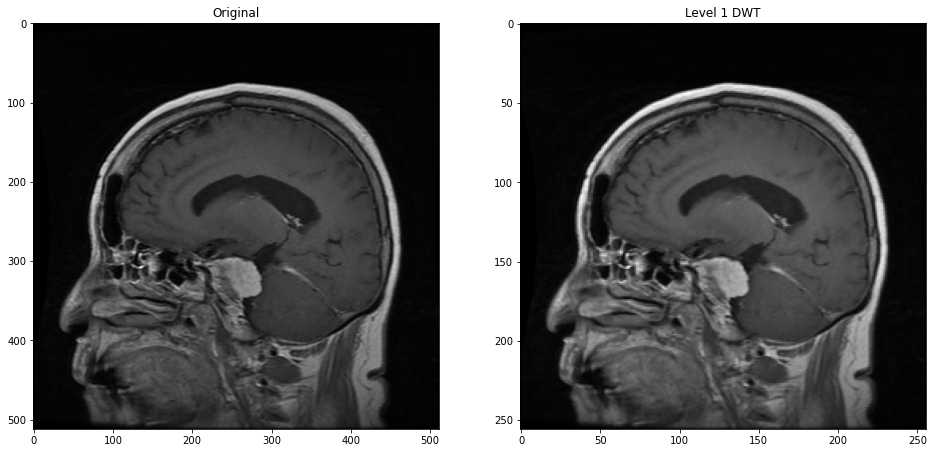

In [103]:
img = imread('./dataset/image/IMAGE_0000.jpg', as_gray = True)
coeffs = pywt.dwt2(img, 'haar')
LL, (LH, HL, HH) = coeffs

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
# fig.suptitle('Original vs Discrete Wavelet Transformed')
axs[0].set_title('Original')
axs[0].imshow(img, cmap=plt.cm.gray)
axs[1].set_title('Level 1 DWT')
axs[1].imshow(LL, cmap=plt.cm.gray)

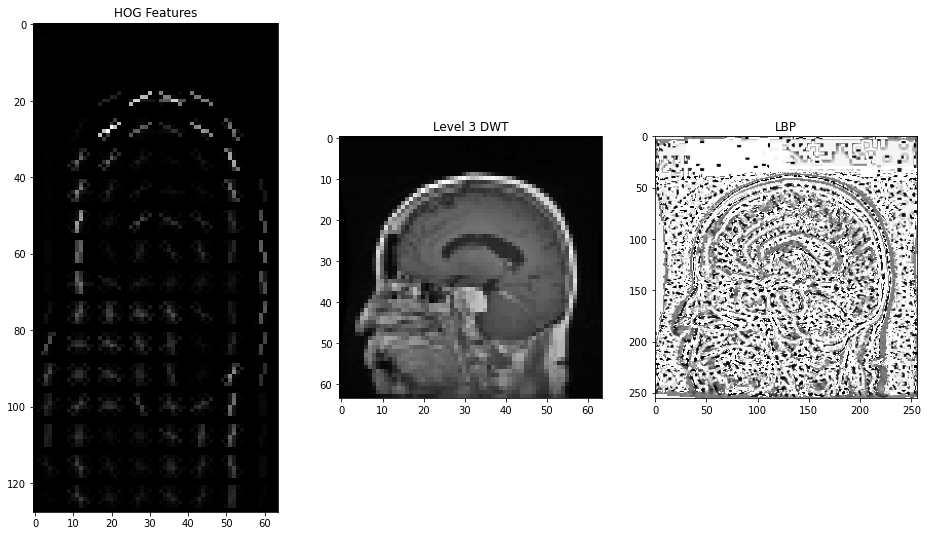

In [104]:
fd, hog_img = hog(resize(LL, (128, 64)), orientations=9, pixels_per_cell=(8, 8),
                  cells_per_block=(4, 4), visualize=True, block_norm='L2-Hys')

coeffs2 = pywt.dwt2(LL, 'haar')
LL2, (LH2, HL2, HH2) = coeffs2
coeffs3 = pywt.dwt2(LL2, 'haar')
LL3, (LH3, HL3, HH3) = coeffs3

lbp = local_binary_pattern(LL, 24, 3, method="uniform")

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 9))
# fig.suptitle('Texture Features Used')
axs[0].set_title('HOG Features')
axs[0].imshow(hog_img, cmap=plt.cm.gray)

axs[1].set_title('Level 3 DWT')
axs[1].imshow(LL3, cmap=plt.cm.gray)

axs[2].set_title('LBP')
axs[2].imshow(lbp, cmap=plt.cm.gray)

In [105]:
feature = 'hog'

if feature == 'hog':
    # Doing classification with image HOG features
    label_taskA = pd.read_pickle("./dataset/label_taskA_hog.pkl")
elif feature == 'lbp':
    # Doing classification with image LBP features
    label_taskA = pd.read_pickle("./dataset/label_taskA_lbp.pkl")
# elif feature == 'canny':
#     # Doing classification with Canny filtered image data
#     label_taskA = pd.read_pickle("./dataset/label_taskA_canny.pkl")
elif feature == 'multidwt':
    # Doing classification with Multi-DWT image data
    label_taskA = pd.read_pickle("./dataset/label_taskA_multidwt.pkl")
elif feature == 'hoglbp':
    # Doing classification with image HOG and LBP features
    hog_features = pd.read_pickle("./dataset/label_taskA_hog.pkl")
    lbp_features = pd.read_pickle("./dataset/label_taskA_lbp.pkl")
    # Concatenate tables column-wise and remove extra 'binary_label' column
    label_taskA = pd.concat(
        [hog_features.drop('binary_label', axis=1), lbp_features], axis=1)

X = label_taskA.drop('binary_label', axis=1)  # All other features
Y = label_taskA['binary_label']  # binary label

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=3, shuffle=True, stratify=Y)

print('train set: {}  | test set: {}'.format(round(((len(y_train)*1.0)/len(X)), 3),
                                             round((len(y_test)*1.0)/len(X), 3)))

# the built-in function to standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()

# fit scaler to training dataset
scaler.fit(X_train)
# transform training and test dataset with fitted scaler
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f'{X_train.shape[1]} features before PCA')
# Sanity check
print(('Train set mean = {mean:.2f}, Train set var = {var:.2f}').format(
    mean=X_train.mean(), var=X_train.var()))

train set: 0.7  | test set: 0.3
9360 features before PCA
Train set mean = -0.00, Train set var = 1.00


In [106]:
pd.Series(Y).value_counts()

1    2546
0    1362
Name: binary_label, dtype: int64

In [107]:
# Y = create_binary(df) + [0]*2*len(noTumor_idx)
# X = extract_hog(images_new)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, Y, test_size=0.3, random_state=3, shuffle=True, stratify=Y)

# print('train set: {}  | test set: {}'.format(round(((len(y_train)*1.0)/len(X)), 3),
#                                              round((len(y_test)*1.0)/len(X), 3)))

# # the built-in function to standardize features by removing the mean and scaling to unit variance
# scaler = StandardScaler()

# # fit scaler to training dataset
# scaler.fit(X_train)
# # transform training and test dataset with fitted scaler
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# print(f'{X_train.shape[1]} features before PCA')
# # Sanity check
# print(('Train set mean = {mean:.2f}, Train set var = {var:.2f}').format(
#     mean=X_train.mean(), var=X_train.var()))

In [108]:
# # GRIDSEARCHCV
# def SVMClassifierCV(X_train, y_train, X_test):
#     '''
#     Inputs
#         X_train: Training dataset;
#         y_train: Training labels;
#         X_test: Testing dataset.

#     Return
#         Y_pred: Predicted labels from X_test using SVM.
#     '''

#     # Create dictionary of parameters to cross validate the estimator on
#     # linear was considered in another function as kernel='linear' took very long to compute
# #     parameters = [
# #         {"svc__kernel": ["rbf"], "svc__gamma": ['scale', 'auto'], "svc__C": [1, 10, 100],
# #          "pca__n_components": [0.95, 0.96, 0.97]},
# #         {"svc__kernel": ["poly"], "svc__gamma": ['scale', 'auto'], "svc__C": [1, 10, 100], "svc__degree": [2, 3, 4],
# #          "pca__n_components": [0.95, 0.96, 0.97]}
# #     ]
#     parameters = [
#         {"svc__kernel": ["rbf"], "svc__gamma": ['scale', 'auto'], "svc__C": [1, 10, 100],
#          "pca__n_components": [100, 150, 200]},
#         {"svc__kernel": ["poly"], "svc__gamma": ['scale', 'auto'], "svc__C": [1, 10, 100], "svc__degree": [2, 3],
#          "pca__n_components": [100, 150, 200]}
#     ]

#     matthews = metrics.make_scorer(metrics.matthews_corrcoef)
#     scoring = {'AUC': 'roc_auc', 'matthews': matthews}

#     pca = PCA()
#     # Create SVC object
#     svc = svm.SVC(probability=True)

#     pca_svc = Pipeline(steps=[('pca', pca), ('svc', svc)])
#     # Exhaustive search over all chosen parameters
#     clf = GridSearchCV(pca_svc,
#                        parameters,
#                        scoring=scoring,
#                        refit='matthews',  # use matthews for refit due to imbalanced data
#                        verbose=4,
#                        cv=3,
#                        n_jobs=1,
#                        return_train_score=True)
#     # Fit SVC model with the parameters for cross-validation
#     clf.fit(X_train, y_train)
#     # Predict labels with the best parameters from cross-validation
#     print(clf.best_params_)

#     results=pd.DataFrame.from_dict(clf.cv_results_).sort_values(
#         by = ['rank_test_matthews'])
#     results=results[['params', 'mean_train_AUC', 'mean_test_AUC', 'rank_test_AUC',
#                        'mean_train_matthews', 'mean_test_matthews', 'rank_test_matthews']]

#     # Predict labels with the best parameters from cross-validation
#     Y_pred=clf.predict(X_test)

#     fig, ax=plt.subplots()
#     metrics.ConfusionMatrixDisplay.from_predictions(
#         y_test,
#         Y_pred,
#         cmap = plt.cm.Blues,
#         normalize = 'true',
#         ax = ax,
#         display_labels = ['No tumor', 'Tumor']
#     )
#     ax.set_title('SVM Classifier')

#     return Y_pred, results

# Y_pred_SVM, results_SVM=SVMClassifierCV(X_train, y_train, X_test)
# print(metrics.classification_report(
#     y_test, Y_pred_SVM, target_names=['No tumor', 'Tumor']))
# display(results_SVM)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 85
max_resources_: 2735
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 54
n_resources: 85
Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END pca__n_components=0.97, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.970, test=-0.116) total time=   0.0s
[CV 2/5] END pca__n_components=0.97, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.971, test=0.537) total time=   0.0s
[CV 3/5] END pca__n_components=0.97, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.227) total time=   0.0s
[CV 4/5] END pca__n_components=0.97, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.566) total time=   0.0s
[CV 5/5] END pca__n_components=0.97, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.566) total time=   0.0s
[CV 1/5] END pca__n_components=0.97, svc__C=1, svc__gamma=auto, svc__

[CV 2/5] END pca__n_components=0.99, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.971, test=0.537) total time=   0.0s
[CV 3/5] END pca__n_components=0.99, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.227) total time=   0.0s
[CV 4/5] END pca__n_components=0.99, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.494) total time=   0.0s
[CV 5/5] END pca__n_components=0.99, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.566) total time=   0.0s
[CV 1/5] END pca__n_components=0.99, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 2/5] END pca__n_components=0.99, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 3/5] END pca__n_components=0.99, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 4/5] END pca__n_components=0.99, svc__C=1, svc__gamma=auto, s

[CV 3/5] END pca__n_components=0.97, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.383) total time=   0.0s
[CV 4/5] END pca__n_components=0.97, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.306) total time=   0.0s
[CV 5/5] END pca__n_components=0.97, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=-0.161) total time=   0.0s
[CV 1/5] END pca__n_components=0.97, svc__C=10, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 2/5] END pca__n_components=0.97, svc__C=10, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.742) total time=   0.0s
[CV 3/5] END pca__n_components=0.97, svc__C=10, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.383) total time=   0.0s
[CV 4/5] END pca__n_components=0.97, svc__C=10, svc__degree=3, svc__gamma=auto, svc__kernel=poly

[CV 2/5] END pca__n_components=0.98, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.742) total time=   0.0s
[CV 3/5] END pca__n_components=0.98, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.383) total time=   0.0s
[CV 4/5] END pca__n_components=0.98, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.387) total time=   0.0s
[CV 5/5] END pca__n_components=0.98, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=-0.161) total time=   0.0s
[CV 1/5] END pca__n_components=0.98, svc__C=10, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 2/5] END pca__n_components=0.98, svc__C=10, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.874) total time=   0.0s
[CV 3/5] END pca__n_components=0.98, svc__C=10, svc__degree=3, svc__gamma=auto, svc__kernel=pol

[CV 1/5] END pca__n_components=0.99, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 2/5] END pca__n_components=0.99, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.751) total time=   0.0s
[CV 3/5] END pca__n_components=0.99, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.485) total time=   0.0s
[CV 4/5] END pca__n_components=0.99, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.387) total time=   0.0s
[CV 5/5] END pca__n_components=0.99, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=-0.161) total time=   0.0s
[CV 1/5] END pca__n_components=0.99, svc__C=10, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 2/5] END pca__n_components=0.99, svc__C=10, svc__degree=3, svc__gamma=auto, svc__kernel=po

[CV 1/5] END pca__n_components=0.97, svc__C=10, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.376) total time=   0.0s
[CV 2/5] END pca__n_components=0.97, svc__C=10, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.609) total time=   0.0s
[CV 3/5] END pca__n_components=0.97, svc__C=10, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.316) total time=   0.0s
[CV 4/5] END pca__n_components=0.97, svc__C=10, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.471) total time=   0.0s
[CV 5/5] END pca__n_components=0.97, svc__C=10, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.354) total time=   0.0s
[CV 1/5] END pca__n_components=0.98, svc__C=10, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.376) total time=   0.0s
[CV 2/5] END pca__n_components=0.98, svc__C=10, svc__degree=2, svc__gamma=scale, svc__kernel=poly;,

[CV 1/5] END pca__n_components=0.98, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.595) total time=   0.0s
[CV 2/5] END pca__n_components=0.98, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.827) total time=   0.0s
[CV 3/5] END pca__n_components=0.98, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.469) total time=   0.0s
[CV 4/5] END pca__n_components=0.98, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.767) total time=   0.0s
[CV 5/5] END pca__n_components=0.98, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.969, test=0.519) total time=   0.0s
[CV 1/5] END pca__n_components=0.97, svc__C=1, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 2/5] END pca__n_components=0.97, svc__C=1, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.553) total time=   0.0s
[CV 3/5] END pca__n_components=0

[CV 4/5] END pca__n_components=0.98, svc__C=100, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.685) total time=   0.1s
[CV 5/5] END pca__n_components=0.98, svc__C=100, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.800) total time=   0.1s
[CV 1/5] END pca__n_components=0.98, svc__C=100, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.767) total time=   0.1s
[CV 2/5] END pca__n_components=0.98, svc__C=100, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.680) total time=   0.1s
[CV 3/5] END pca__n_components=0.98, svc__C=100, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.524) total time=   0.1s
[CV 4/5] END pca__n_components=0.98, svc__C=100, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.685) total time=   0.1s
[CV 5/5] END pca__n_components=0.98, svc__C=100, svc__degree=2, svc__gamma=scale, svc__ker

[CV 3/5] END pca__n_components=0.99, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.969, test=0.653) total time=   0.1s
[CV 4/5] END pca__n_components=0.99, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.992, test=0.846) total time=   0.2s
[CV 5/5] END pca__n_components=0.99, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.984, test=0.766) total time=   0.2s
[CV 1/5] END pca__n_components=0.97, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.960, test=0.623) total time=   0.2s
[CV 2/5] END pca__n_components=0.97, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.977, test=0.680) total time=   0.1s
[CV 3/5] END pca__n_components=0.97, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.962, test=0.653) total time=   0.1s
[CV 4/5] END pca__n_components=0.97, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.985, test=0.846) total time=   0.1s
[CV 5/5] END pca__n_components=0.97, svc__C=1, svc__gamma=scal

[CV 2/5] END pca__n_components=0.98, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.895) total time=   5.6s
[CV 3/5] END pca__n_components=0.98, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.855) total time=   5.4s
[CV 4/5] END pca__n_components=0.98, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.859) total time=   5.5s
[CV 5/5] END pca__n_components=0.98, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.850) total time=   5.6s
----------
iter: 5
n_candidates: 2
n_resources: 2720
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.911) total time=  22.0s
[CV 2/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.915) total time=  21.3s
[CV 3/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale, svc__ke

,params,mean_train_score,mean_test_score,rank_test_score
107,"{'pca__n_components': 0.98, 'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",1.000000,0.900677,1
106,"{'pca__n_components': 0.98, 'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",1.000000,0.900677,1
105,"{'pca__n_components': 0.98, 'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",1.000000,0.866619,3
104,"{'pca__n_components': 0.98, 'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",1.000000,0.866619,3
103,"{'pca__n_components': 0.99, 'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",1.000000,0.863608,5
...,...,...,...,...
5,"{'pca__n_components': 0.97, 'svc__C': 100, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}",1.000000,0.000000,97
3,"{'pca__n_components': 0.97, 'svc__C': 10, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}",1.000000,0.000000,97
1,"{'pca__n_components': 0.97, 'svc__C': 1, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}",1.000000,0.000000,97
32,"{'pca__n_components': 0.98, 'svc__C': 1, 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.782933,0.000000,97


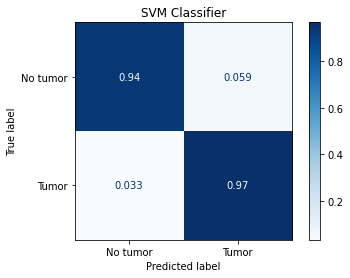

In [109]:
def SVMClassifierCV(X_train, y_train, X_test):
    '''
    Inputs
        X_train: Training dataset;
        y_train: Training labels;
        X_test: Testing dataset.

    Return
        Y_pred: Predicted labels from X_test using SVM.
    '''

    # Create dictionary of parameters to cross validate the estimator on
    # linear was considered in another function as kernel='linear' took very long to compute
    parameters = [
        {"svc__kernel": ["rbf"], "svc__gamma": ['scale', 'auto'], "svc__C": [1, 10, 100],
         "pca__n_components": [0.97, 0.98, 0.99]},
        {"svc__kernel": ["poly"], "svc__gamma": ['scale', 'auto'], "svc__C": [1, 10, 100], "svc__degree": [2, 3],
         "pca__n_components": [0.97, 0.98, 0.99]}
    ]

    matthews = metrics.make_scorer(metrics.matthews_corrcoef)

    # Create PCA object
    pca = PCA()
    # Create SVC object
    svc = svm.SVC(probability=True)

    pca_svc = Pipeline(steps=[('pca', pca), ('svc', svc)])

    # Exhaustive search over all chosen parameters
    clf = HalvingGridSearchCV(pca_svc,
                              parameters,
                              factor=2,
                              scoring=matthews,
                              refit=True,
                              verbose=4,
                              cv=5,
                              n_jobs=1,
                              random_state=42,
                              return_train_score=True)
    # Fit SVC model with the parameters for cross-validation
    clf.fit(X_train, y_train)
    # Predict labels with the best parameters from cross-validation
    print(clf.best_params_)

    results = pd.DataFrame.from_dict(
        clf.cv_results_).sort_values(by=['rank_test_score'])
    results = results[['params', 'mean_train_score',
                       'mean_test_score', 'rank_test_score']]

    # Predict labels with the best parameters from cross-validation
    Y_pred = clf.predict(X_test)

    fig, ax = plt.subplots()
    metrics.ConfusionMatrixDisplay.from_predictions(
        y_test,
        Y_pred,
        cmap=plt.cm.Blues,
        normalize='true',
        ax=ax,
        display_labels=['No tumor', 'Tumor']
    )
    ax.set_title('SVM Classifier')

    return Y_pred, results


Y_pred_SVM, results_SVM = SVMClassifierCV(X_train, y_train, X_test)
print(metrics.classification_report(
    y_test, Y_pred_SVM, target_names=['No tumor', 'Tumor']))
pd.set_option('display.max_colwidth', None)
display(results_SVM)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 47
max_resources_: 3053
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 87
n_resources: 47
Fitting 5 folds for each of 87 candidates, totalling 435 fits
[CV 1/5] END neigh__n_neighbors=1, pca__n_components=0.96;, score=(train=1.000, test=0.598) total time=   0.1s
[CV 2/5] END neigh__n_neighbors=1, pca__n_components=0.96;, score=(train=1.000, test=0.791) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=1, pca__n_components=0.96;, score=(train=1.000, test=0.791) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=1, pca__n_components=0.96;, score=(train=1.000, test=0.598) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=1, pca__n_components=0.96;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=1, pca__n_components=0.97;, score=(train=1.000, test=0.791) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=1, pca__n_components=0.97;, score=(train=1

[CV 2/5] END neigh__n_neighbors=6, pca__n_components=0.96;, score=(train=0.478, test=0.500) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=6, pca__n_components=0.96;, score=(train=0.650, test=0.500) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=6, pca__n_components=0.96;, score=(train=0.676, test=0.060) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=6, pca__n_components=0.96;, score=(train=0.590, test=0.756) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=6, pca__n_components=0.97;, score=(train=0.439, test=0.395) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=6, pca__n_components=0.97;, score=(train=0.571, test=0.500) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=6, pca__n_components=0.97;, score=(train=0.650, test=0.500) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=6, pca__n_components=0.97;, score=(train=0.676, test=0.060) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=6, pca__n_components=0.97;, score=(train=0.636, test=0.756) total time=   0.0s
[

[CV 4/5] END neigh__n_neighbors=11, pca__n_components=0.96;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=11, pca__n_components=0.96;, score=(train=0.256, test=0.000) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=11, pca__n_components=0.97;, score=(train=0.325, test=0.000) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=11, pca__n_components=0.97;, score=(train=0.345, test=0.000) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=11, pca__n_components=0.97;, score=(train=0.345, test=0.000) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=11, pca__n_components=0.97;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=11, pca__n_components=0.97;, score=(train=0.256, test=0.000) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=11, pca__n_components=0.98;, score=(train=0.404, test=0.000) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=11, pca__n_components=0.98;, score=(train=0.345, test=0.000) total time=

[CV 3/5] END neigh__n_neighbors=16, pca__n_components=0.97;, score=(train=0.241, test=0.000) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=16, pca__n_components=0.97;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=16, pca__n_components=0.97;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=16, pca__n_components=0.98;, score=(train=0.325, test=0.000) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=16, pca__n_components=0.98;, score=(train=0.241, test=0.000) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=16, pca__n_components=0.98;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=16, pca__n_components=0.98;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=16, pca__n_components=0.98;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=17, pca__n_components=0.96;, score=(train=0.000, test=0.000) total time=

[CV 1/5] END neigh__n_neighbors=21, pca__n_components=0.98;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=21, pca__n_components=0.98;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=21, pca__n_components=0.98;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=21, pca__n_components=0.98;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=21, pca__n_components=0.98;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=22, pca__n_components=0.96;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=22, pca__n_components=0.96;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=22, pca__n_components=0.96;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=22, pca__n_components=0.96;, score=(train=0.000, test=0.000) total time=

[CV 2/5] END neigh__n_neighbors=27, pca__n_components=0.96;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=27, pca__n_components=0.96;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=27, pca__n_components=0.96;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=27, pca__n_components=0.96;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=27, pca__n_components=0.97;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=27, pca__n_components=0.97;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=27, pca__n_components=0.97;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=27, pca__n_components=0.97;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=27, pca__n_components=0.97;, score=(train=0.000, test=0.000) total time=

[CV 2/5] END neigh__n_neighbors=12, pca__n_components=0.98;, score=(train=0.368, test=0.000) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=12, pca__n_components=0.98;, score=(train=0.397, test=0.500) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=12, pca__n_components=0.98;, score=(train=0.535, test=0.500) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=12, pca__n_components=0.98;, score=(train=0.473, test=0.663) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=12, pca__n_components=0.97;, score=(train=0.440, test=-0.193) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=12, pca__n_components=0.97;, score=(train=0.368, test=0.000) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=12, pca__n_components=0.97;, score=(train=0.388, test=0.500) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=12, pca__n_components=0.97;, score=(train=0.517, test=0.500) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=12, pca__n_components=0.97;, score=(train=0.473, test=0.791) total time

[CV 1/5] END neigh__n_neighbors=5, pca__n_components=0.96;, score=(train=0.456, test=0.000) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=5, pca__n_components=0.96;, score=(train=0.441, test=0.000) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=5, pca__n_components=0.96;, score=(train=0.674, test=0.791) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=5, pca__n_components=0.96;, score=(train=0.615, test=0.500) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=5, pca__n_components=0.96;, score=(train=0.624, test=0.553) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=8, pca__n_components=0.97;, score=(train=0.616, test=0.304) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=8, pca__n_components=0.97;, score=(train=0.536, test=0.217) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=8, pca__n_components=0.97;, score=(train=0.538, test=0.791) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=8, pca__n_components=0.97;, score=(train=0.561, test=0.598) total time=   0.0s
[

[CV 1/5] END neigh__n_neighbors=2, pca__n_components=0.96;, score=(train=0.917, test=0.670) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=2, pca__n_components=0.96;, score=(train=0.911, test=0.632) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=2, pca__n_components=0.96;, score=(train=0.916, test=0.707) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=2, pca__n_components=0.96;, score=(train=0.784, test=0.671) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=2, pca__n_components=0.96;, score=(train=0.782, test=0.671) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=5, pca__n_components=0.97;, score=(train=0.538, test=0.304) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=5, pca__n_components=0.97;, score=(train=0.483, test=0.217) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=5, pca__n_components=0.97;, score=(train=0.601, test=0.791) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=5, pca__n_components=0.97;, score=(train=0.588, test=0.500) total time=   0.0s
[

[CV 1/5] END neigh__n_neighbors=8, pca__n_components=0.98;, score=(train=0.624, test=0.446) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=8, pca__n_components=0.98;, score=(train=0.525, test=0.399) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=8, pca__n_components=0.98;, score=(train=0.621, test=0.714) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=8, pca__n_components=0.98;, score=(train=0.632, test=0.429) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=8, pca__n_components=0.98;, score=(train=0.667, test=0.545) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=5, pca__n_components=0.97;, score=(train=0.573, test=0.446) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=5, pca__n_components=0.97;, score=(train=0.587, test=0.340) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=5, pca__n_components=0.97;, score=(train=0.653, test=0.714) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=5, pca__n_components=0.97;, score=(train=0.659, test=0.429) total time=   0.0s
[

[CV 5/5] END neigh__n_neighbors=2, pca__n_components=0.96;, score=(train=0.848, test=0.502) total time=   0.0s
----------
iter: 3
n_candidates: 11
n_resources: 376
Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5] END neigh__n_neighbors=6, pca__n_components=0.96;, score=(train=0.774, test=0.565) total time=   0.1s
[CV 2/5] END neigh__n_neighbors=6, pca__n_components=0.96;, score=(train=0.762, test=0.692) total time=   0.1s
[CV 3/5] END neigh__n_neighbors=6, pca__n_components=0.96;, score=(train=0.835, test=0.894) total time=   0.1s
[CV 4/5] END neigh__n_neighbors=6, pca__n_components=0.96;, score=(train=0.742, test=0.741) total time=   0.1s
[CV 5/5] END neigh__n_neighbors=6, pca__n_components=0.96;, score=(train=0.789, test=0.720) total time=   0.1s
[CV 1/5] END neigh__n_neighbors=6, pca__n_components=0.97;, score=(train=0.781, test=0.638) total time=   0.1s
[CV 2/5] END neigh__n_neighbors=6, pca__n_components=0.97;, score=(train=0.763, test=0.668) total time=   0.1

[CV 2/5] END neigh__n_neighbors=2, pca__n_components=0.96;, score=(train=0.949, test=0.785) total time=   1.4s
[CV 3/5] END neigh__n_neighbors=2, pca__n_components=0.96;, score=(train=0.947, test=0.837) total time=   1.4s
[CV 4/5] END neigh__n_neighbors=2, pca__n_components=0.96;, score=(train=0.928, test=0.785) total time=   1.4s
[CV 5/5] END neigh__n_neighbors=2, pca__n_components=0.96;, score=(train=0.929, test=0.798) total time=   1.4s
[CV 1/5] END neigh__n_neighbors=2, pca__n_components=0.97;, score=(train=0.950, test=0.775) total time=   1.4s
[CV 2/5] END neigh__n_neighbors=2, pca__n_components=0.97;, score=(train=0.946, test=0.799) total time=   1.4s
[CV 3/5] END neigh__n_neighbors=2, pca__n_components=0.97;, score=(train=0.947, test=0.851) total time=   1.4s
[CV 4/5] END neigh__n_neighbors=2, pca__n_components=0.97;, score=(train=0.928, test=0.812) total time=   1.3s
[CV 5/5] END neigh__n_neighbors=2, pca__n_components=0.97;, score=(train=0.929, test=0.783) total time=   1.4s
[

,params,mean_train_score,mean_test_score,rank_test_score
174,"{'neigh__n_neighbors': 2, 'pca__n_components': 0.97}",0.969984,0.873941,1
173,"{'neigh__n_neighbors': 2, 'pca__n_components': 0.98}",0.970477,0.871239,2
171,"{'neigh__n_neighbors': 2, 'pca__n_components': 0.97}",0.959698,0.825475,3
172,"{'neigh__n_neighbors': 2, 'pca__n_components': 0.98}",0.960666,0.825385,4
170,"{'neigh__n_neighbors': 2, 'pca__n_components': 0.96}",0.959052,0.822602,5
...,...,...,...,...
63,"{'neigh__n_neighbors': 22, 'pca__n_components': 0.96}",0.000000,0.000000,120
62,"{'neigh__n_neighbors': 21, 'pca__n_components': 0.98}",0.000000,0.000000,120
61,"{'neigh__n_neighbors': 21, 'pca__n_components': 0.97}",0.000000,0.000000,120
72,"{'neigh__n_neighbors': 25, 'pca__n_components': 0.96}",0.000000,0.000000,120


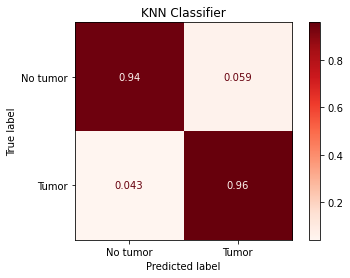

In [94]:
def KNNClassifierCV(X_train, y_train, X_test):
    '''
    Inputs
        X_train: Training dataset;
        y_train: Training labels;
        X_test: Testing dataset;

    Return
        Y_pred: Predicted labels from X_test using K-Nearest Neighbour.
    '''

    # Create dictionary of parameters to cross validate the estimator on
#     parameters = {'neigh__n_neighbors': range(1, math.floor(math.sqrt(X_train.shape[0])), 1),
#                   "pca__n_components": [0.96, 0.97, 0.98]}
    parameters = {'neigh__n_neighbors': range(1, 30, 1),
                  "pca__n_components": [0.96, 0.97, 0.98]}

    matthews = metrics.make_scorer(metrics.matthews_corrcoef)

    # Create PCA object
    pca = PCA()

    # Create KNN object
    neigh = KNeighborsClassifier(algorithm='auto')

    pca_neigh = Pipeline(steps=[('pca', pca), ('neigh', neigh)])

    # Exhaustive search over all chosen parameters
    clf = HalvingGridSearchCV(pca_neigh,
                              parameters,
                              factor=2,
                              scoring=matthews,
                              refit=True,
                              verbose=4,
                              cv=5,
                              n_jobs=1,
                              random_state=42,
                              return_train_score=True)
#     # Exhaustive search over all chosen parameters
#     clf = GridSearchCV(neigh,
#                        parameters,
#                        scoring=scoring,
#                        refit='matthews', # use matthews for refit due to imbalanced data
#                        cv=3,
#                        verbose=1,
#                        return_train_score=True)

    # Fit KNN model with the parameters for cross-validation
    clf.fit(X_train, y_train)
    # Predict labels with the best parameters from cross-validation
    print(clf.best_params_)

    results = pd.DataFrame.from_dict(
        clf.cv_results_).sort_values(by=['rank_test_score'])
    results = results[['params', 'mean_train_score',
                       'mean_test_score', 'rank_test_score']]

    # Predict labels with the best parameters from cross-validation
    Y_pred = clf.predict(X_test)

    fig, ax = plt.subplots()
    metrics.ConfusionMatrixDisplay.from_predictions(
        y_test,
        Y_pred,
        cmap=plt.cm.Reds,
        normalize='true',
        ax=ax,
        display_labels=['No tumor', 'Tumor']
    )
    ax.set_title('KNN Classifier')

    return Y_pred, results


Y_pred_KNN, results_KNN = KNNClassifierCV(X_train, y_train, X_test)
print(metrics.classification_report(
    y_test, Y_pred_KNN, target_names=['No tumor', 'Tumor']))
pd.set_option('display.max_colwidth', None)
display(results_KNN)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 190
max_resources_: 3053
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 21
n_resources: 190
Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5] END abc__n_estimators=50, pca__n_components=0.97;, score=(train=1.000, test=0.676) total time=   0.2s
[CV 2/5] END abc__n_estimators=50, pca__n_components=0.97;, score=(train=1.000, test=0.464) total time=   0.1s
[CV 3/5] END abc__n_estimators=50, pca__n_components=0.97;, score=(train=1.000, test=0.714) total time=   0.2s
[CV 4/5] END abc__n_estimators=50, pca__n_components=0.97;, score=(train=1.000, test=0.294) total time=   0.2s
[CV 5/5] END abc__n_estimators=50, pca__n_components=0.97;, score=(train=1.000, test=0.489) total time=   0.1s
[CV 1/5] END abc__n_estimators=50, pca__n_components=0.98;, score=(train=1.000, test=0.676) total time=   0.1s
[CV 2/5] END abc__n_estimators=50, pca__n_components=0.98;, score=(train

[CV 2/5] END abc__n_estimators=250, pca__n_components=0.99;, score=(train=1.000, test=0.664) total time=   0.6s
[CV 3/5] END abc__n_estimators=250, pca__n_components=0.99;, score=(train=1.000, test=0.829) total time=   0.6s
[CV 4/5] END abc__n_estimators=250, pca__n_components=0.99;, score=(train=1.000, test=0.489) total time=   0.6s
[CV 5/5] END abc__n_estimators=250, pca__n_components=0.99;, score=(train=1.000, test=0.661) total time=   0.6s
[CV 1/5] END abc__n_estimators=300, pca__n_components=0.97;, score=(train=1.000, test=0.567) total time=   0.7s
[CV 2/5] END abc__n_estimators=300, pca__n_components=0.97;, score=(train=1.000, test=0.664) total time=   0.6s
[CV 3/5] END abc__n_estimators=300, pca__n_components=0.97;, score=(train=1.000, test=0.772) total time=   0.6s
[CV 4/5] END abc__n_estimators=300, pca__n_components=0.97;, score=(train=1.000, test=0.362) total time=   0.7s
[CV 5/5] END abc__n_estimators=300, pca__n_components=0.97;, score=(train=1.000, test=0.661) total time=

[CV 5/5] END abc__n_estimators=350, pca__n_components=0.98;, score=(train=1.000, test=0.742) total time=   2.3s
[CV 1/5] END abc__n_estimators=200, pca__n_components=0.97;, score=(train=1.000, test=0.739) total time=   1.3s
[CV 2/5] END abc__n_estimators=200, pca__n_components=0.97;, score=(train=1.000, test=0.655) total time=   1.3s
[CV 3/5] END abc__n_estimators=200, pca__n_components=0.97;, score=(train=1.000, test=0.735) total time=   1.3s
[CV 4/5] END abc__n_estimators=200, pca__n_components=0.97;, score=(train=1.000, test=0.626) total time=   1.3s
[CV 5/5] END abc__n_estimators=200, pca__n_components=0.97;, score=(train=1.000, test=0.742) total time=   1.4s
[CV 1/5] END abc__n_estimators=200, pca__n_components=0.98;, score=(train=1.000, test=0.609) total time=   1.4s
[CV 2/5] END abc__n_estimators=200, pca__n_components=0.98;, score=(train=1.000, test=0.587) total time=   1.3s
[CV 3/5] END abc__n_estimators=200, pca__n_components=0.98;, score=(train=1.000, test=0.796) total time=

{'abc__n_estimators': 350, 'pca__n_components': 0.97}
              precision    recall  f1-score   support

    No tumor       0.89      0.91      0.90       545
       Tumor       0.94      0.92      0.93       764

    accuracy                           0.92      1309
   macro avg       0.91      0.91      0.91      1309
weighted avg       0.92      0.92      0.92      1309



,params,mean_train_score,mean_test_score,rank_test_score
42,"{'abc__n_estimators': 350, 'pca__n_components': 0.97}",1.0,0.839009,1
41,"{'abc__n_estimators': 250, 'pca__n_components': 0.97}",1.0,0.828473,2
39,"{'abc__n_estimators': 350, 'pca__n_components': 0.97}",1.0,0.778125,3
38,"{'abc__n_estimators': 250, 'pca__n_components': 0.97}",1.0,0.763467,4
40,"{'abc__n_estimators': 250, 'pca__n_components': 0.99}",1.0,0.761759,5
35,"{'abc__n_estimators': 250, 'pca__n_components': 0.99}",1.0,0.723198,6
36,"{'abc__n_estimators': 350, 'pca__n_components': 0.97}",1.0,0.716757,7
34,"{'abc__n_estimators': 250, 'pca__n_components': 0.97}",1.0,0.710328,8
33,"{'abc__n_estimators': 150, 'pca__n_components': 0.97}",1.0,0.705062,9
29,"{'abc__n_estimators': 200, 'pca__n_components': 0.97}",1.0,0.699541,10


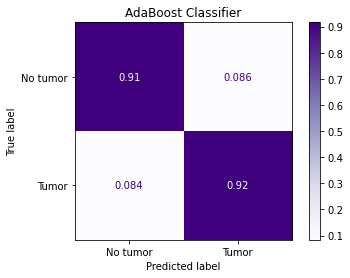

In [95]:
def ABClassifierCV(X_train, y_train, X_test):
    '''
    Inputs
        X_train: Training dataset;
        y_train: Training labels;
        X_test: Testing dataset;

    Return
        Y_pred: Predicted labels from X_test using K-Nearest Neighbour.
    '''

    # Create dictionary of parameters to cross validate the estimator on
    parameters = {'abc__n_estimators': range(50, 400, 50),
                  "pca__n_components": [0.97, 0.98, 0.99]}

    matthews = metrics.make_scorer(metrics.matthews_corrcoef)

    # Create PCA object
    pca = PCA()

    # Create KNN object
    abc = AdaBoostClassifier(random_state=42)

    pca_abc = Pipeline(steps=[('pca', pca), ('abc', abc)])

    # Exhaustive search over all chosen parameters
    clf = HalvingGridSearchCV(pca_abc,
                              parameters,
                              factor=2,
                              scoring=matthews,
                              refit=True,
                              verbose=4,
                              cv=5,
                              n_jobs=1,
                              random_state=42,
                              return_train_score=True)

    # Fit KNN model with the parameters for cross-validation
    clf.fit(X_train, y_train)
    # Predict labels with the best parameters from cross-validation
    print(clf.best_params_)

    results = pd.DataFrame.from_dict(
        clf.cv_results_).sort_values(by=['rank_test_score'])
    results = results[['params', 'mean_train_score',
                       'mean_test_score', 'rank_test_score']]

    # Predict labels with the best parameters from cross-validation
    Y_pred = clf.predict(X_test)

    fig, ax = plt.subplots()
    metrics.ConfusionMatrixDisplay.from_predictions(
        y_test,
        Y_pred,
        cmap=plt.cm.Purples,
        normalize='true',
        ax=ax,
        display_labels=['No tumor', 'Tumor']
    )
    ax.set_title('AdaBoost Classifier')

    return Y_pred, results


Y_pred_AB, results_AB = ABClassifierCV(X_train, y_train, X_test)
print(metrics.classification_report(
    y_test, Y_pred_AB, target_names=['No tumor', 'Tumor']))
pd.set_option('display.max_colwidth', None)
display(results_AB)